In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

In [5]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [6]:
# Preprocessing der Rohdaten: 46%
ZR_46new=np.atleast_2d(ZR_46)
if ZR_46new.shape[0]==1:
    ZR_46new=ZR_46new.T
nb_samples_46, nb_series_46 = ZR_46new.shape

In [7]:
# Preprocessing der Rohdaten: 12%
ZR_12new=np.atleast_2d(ZR_12)
if ZR_12new.shape[0]==1:
    ZR_12new=ZR_12new.T
nb_samples_12, nb_series_12 = ZR_12new.shape

In [8]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

test_size_12=int(0.35*nb_samples_12)
train_12, test_12 = ZR_12[:-test_size_12], ZR_12[-test_size_12:]

In [9]:
# Shape des Input und Outputs anpassen: 100%
look_forward=1
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (592,) (592, 12, 1)
(1, 12, 1) (245,) (245, 12, 1)


In [10]:
# Shape des Input und Outputs anpassen: 46%
# Trainingsdaten
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=train_46[window_size+look_forward:]
qtrain_46=np.atleast_3d([train_46[-(window_size):]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

# Testdaten
Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=test_46[window_size+look_forward:]
qtest_46=np.atleast_3d([test_46[-(window_size):]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (247,) (247, 12, 1)
(1, 12, 1) (127,) (127, 12, 1)


In [11]:
# Shape des Input und Outputs anpassen: 12%
# Trainingsdaten
Xtrain_12=np.atleast_3d(np.array([train_12[start:start+window_size] for start in range(0, train_12.shape[0]-(window_size+look_forward))]))
ytrain_12=train_12[window_size+look_forward:]
qtrain_12=np.atleast_3d([train_12[-(window_size):]])
print(qtrain_12.shape, ytrain_12.shape, Xtrain_12.shape)

# Testdaten
Xtest_12=np.atleast_3d(np.array([test_12[start:start+window_size] for start in range(0, test_12.shape[0]-(window_size+look_forward))]))
ytest_12=test_12[window_size+look_forward:]
qtest_12=np.atleast_3d([test_12[-(window_size):]])
print(qtest_12.shape, ytest_12.shape, Xtest_12.shape)

(1, 12, 1) (52,) (52, 12, 1)
(1, 12, 1) (22,) (22, 12, 1)


In [12]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  del sys.path[0]


In [13]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total para

In [14]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [15]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 592 samples, validate on 245 samples
Epoch 1/200
592/592 [==============================] - 1s 2ms/step - loss: 2031174639.3986 - mean_absolute_error: 36068.4979 - val_loss: 200078135.5102 - val_mean_absolute_error: 13403.2209
Epoch 2/200
592/592 [==============================] - 0s 345us/step - loss: 115118620.3716 - mean_absolute_error: 8751.4515 - val_loss: 20228236.6122 - val_mean_absolute_error: 3577.9274
Epoch 3/200
592/592 [==============================] - 0s 336us/step - loss: 31653778.3902 - mean_absolute_error: 4468.9000 - val_loss: 19208989.2653 - val_mean_absolute_error: 3529.4155
Epoch 4/200
592/592 [==============================] - 0s 348us/step - loss: 26869294.8226 - mean_absolute_error: 4109.5811 - val_loss: 18511284.8571 - val_mean_absolute_error: 3571.3385
Epoch 5/200
592/592 [==============================] - 0s 329us/step - loss: 26380470.7804 - mean_absolute_error: 4039.0041 - val_loss: 18510232.1429 - val_mean_absolute_error: 3598.2956
Epoch 6/200
592

Epoch 88/200
592/592 [==============================] - 0s 350us/step - loss: 16608888.3716 - mean_absolute_error: 3191.0147 - val_loss: 8624601.9694 - val_mean_absolute_error: 2340.4696
Epoch 89/200
592/592 [==============================] - 0s 328us/step - loss: 16223066.2078 - mean_absolute_error: 3153.7314 - val_loss: 13708365.6735 - val_mean_absolute_error: 2905.7197
Epoch 90/200
592/592 [==============================] - 0s 350us/step - loss: 16949408.6436 - mean_absolute_error: 3245.7592 - val_loss: 8593327.5306 - val_mean_absolute_error: 2360.5561
Epoch 91/200
592/592 [==============================] - 0s 373us/step - loss: 16317729.2770 - mean_absolute_error: 3174.3714 - val_loss: 9155131.8469 - val_mean_absolute_error: 2386.3952
Epoch 92/200
592/592 [==============================] - 0s 380us/step - loss: 17705654.7770 - mean_absolute_error: 3327.6418 - val_loss: 8657589.7347 - val_mean_absolute_error: 2359.5706
Epoch 93/200
592/592 [==============================] - 0s 365us

592/592 [==============================] - 0s 311us/step - loss: 9721393.2677 - mean_absolute_error: 2455.8943 - val_loss: 9708713.5510 - val_mean_absolute_error: 2455.8643
Epoch 175/200
592/592 [==============================] - 0s 321us/step - loss: 9892802.4139 - mean_absolute_error: 2501.6236 - val_loss: 9550615.6837 - val_mean_absolute_error: 2443.9583
Epoch 176/200
592/592 [==============================] - 0s 323us/step - loss: 11597130.5270 - mean_absolute_error: 2661.2801 - val_loss: 9903152.9490 - val_mean_absolute_error: 2503.9820
Epoch 177/200
592/592 [==============================] - 0s 313us/step - loss: 10229832.9941 - mean_absolute_error: 2516.4792 - val_loss: 10426509.9490 - val_mean_absolute_error: 2538.1480
Epoch 178/200
592/592 [==============================] - 0s 323us/step - loss: 10778004.9882 - mean_absolute_error: 2597.8385 - val_loss: 9907832.4694 - val_mean_absolute_error: 2478.5398
Epoch 179/200
592/592 [==============================] - 0s 323us/step - lo

Text(0.5,1,'Loss Curves')

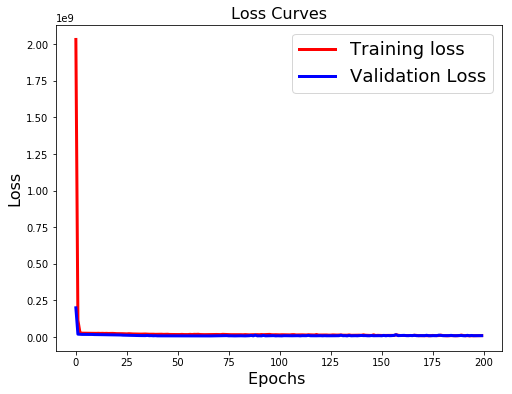

In [16]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

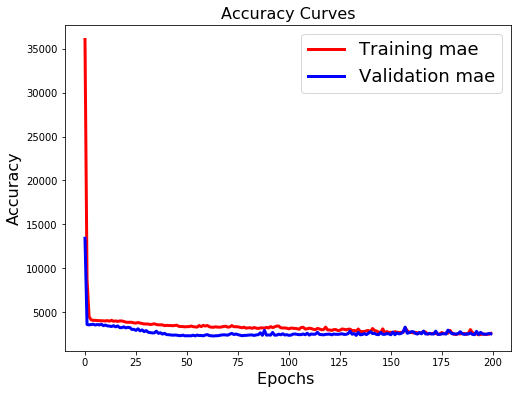

In [17]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [18]:
# Vorhersage generieren
predictions_100 = model.predict(Xtest_100)

predictions_train_100=model.predict(Xtrain_100)

In [19]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100, predictions_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100, predictions_train_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 10086347.000
Train MSE: 8953680.080


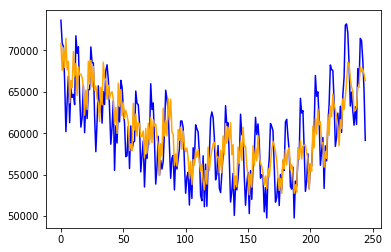

In [20]:
# Vorhersage und Testdaten abtragen
plt.plot(ytest_100, color='blue') 
plt.plot(predictions_100, color='orange') 
plt.show()

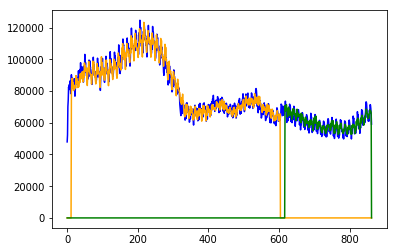

In [21]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_100)+(window_size+look_forward-1)] = predictions_train_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(predictions_train_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = predictions_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [22]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [23]:
# Modellanpassen: 46%
history_reg=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=25, validation_data=(Xtest_46, ytest_46))

Train on 247 samples, validate on 127 samples
Epoch 1/200
247/247 [==============================] - 0s 490us/step - loss: 10554758.0081 - mean_absolute_error: 2571.3724 - val_loss: 8759643.1732 - val_mean_absolute_error: 2292.4838
Epoch 2/200
247/247 [==============================] - 0s 615us/step - loss: 10266938.2996 - mean_absolute_error: 2558.2803 - val_loss: 8825767.2874 - val_mean_absolute_error: 2314.2730
Epoch 3/200
247/247 [==============================] - 0s 555us/step - loss: 9084619.0830 - mean_absolute_error: 2405.6574 - val_loss: 8019156.4449 - val_mean_absolute_error: 2178.5339
Epoch 4/200
247/247 [==============================] - 0s 409us/step - loss: 8806115.1012 - mean_absolute_error: 2360.6567 - val_loss: 7947335.2835 - val_mean_absolute_error: 2182.5366
Epoch 5/200
247/247 [==============================] - 0s 389us/step - loss: 9126151.7004 - mean_absolute_error: 2427.9844 - val_loss: 7512103.1260 - val_mean_absolute_error: 2091.5416
Epoch 6/200
247/247 [======

Epoch 45/200
247/247 [==============================] - 0s 445us/step - loss: 6102025.4464 - mean_absolute_error: 2001.4070 - val_loss: 6169630.3228 - val_mean_absolute_error: 1888.0754
Epoch 46/200
247/247 [==============================] - 0s 429us/step - loss: 6276627.8502 - mean_absolute_error: 2003.3535 - val_loss: 7585772.1535 - val_mean_absolute_error: 2223.4647
Epoch 47/200
247/247 [==============================] - 0s 300us/step - loss: 6590959.4545 - mean_absolute_error: 2063.2546 - val_loss: 6957486.6220 - val_mean_absolute_error: 2095.4112
Epoch 48/200
247/247 [==============================] - 0s 364us/step - loss: 6035264.3887 - mean_absolute_error: 2008.8816 - val_loss: 5983380.0433 - val_mean_absolute_error: 1843.1696
Epoch 49/200
247/247 [==============================] - 0s 324us/step - loss: 6113335.0951 - mean_absolute_error: 1985.0523 - val_loss: 5795139.1024 - val_mean_absolute_error: 1801.0665
Epoch 50/200
247/247 [==============================] - 0s 324us/step 

247/247 [==============================] - 0s 453us/step - loss: 5739061.7470 - mean_absolute_error: 1981.2019 - val_loss: 5755809.5039 - val_mean_absolute_error: 1818.3775
Epoch 90/200
247/247 [==============================] - 0s 417us/step - loss: 5954002.9372 - mean_absolute_error: 1959.0841 - val_loss: 6208979.2283 - val_mean_absolute_error: 1939.1549
Epoch 91/200
247/247 [==============================] - 0s 356us/step - loss: 6016302.8664 - mean_absolute_error: 1988.8570 - val_loss: 6702470.0295 - val_mean_absolute_error: 2048.8994
Epoch 92/200
247/247 [==============================] - 0s 417us/step - loss: 6035148.3806 - mean_absolute_error: 1976.2484 - val_loss: 6053104.3642 - val_mean_absolute_error: 1888.4528
Epoch 93/200
247/247 [==============================] - 0s 401us/step - loss: 5463896.4868 - mean_absolute_error: 1889.0979 - val_loss: 7615205.8465 - val_mean_absolute_error: 2231.8250
Epoch 94/200
247/247 [==============================] - 0s 352us/step - loss: 59829

Epoch 133/200
247/247 [==============================] - 0s 368us/step - loss: 5577493.5314 - mean_absolute_error: 1916.6772 - val_loss: 6479229.9508 - val_mean_absolute_error: 1930.6699
Epoch 134/200
247/247 [==============================] - 0s 393us/step - loss: 5751186.6569 - mean_absolute_error: 1948.7918 - val_loss: 5756768.7146 - val_mean_absolute_error: 1829.5908
Epoch 135/200
247/247 [==============================] - 0s 381us/step - loss: 5165195.3219 - mean_absolute_error: 1841.9840 - val_loss: 5669290.4744 - val_mean_absolute_error: 1812.3443
Epoch 136/200
247/247 [==============================] - 0s 364us/step - loss: 5860858.5547 - mean_absolute_error: 1927.3462 - val_loss: 7231105.8307 - val_mean_absolute_error: 2148.6396
Epoch 137/200
247/247 [==============================] - 0s 425us/step - loss: 5475720.0466 - mean_absolute_error: 1888.0101 - val_loss: 6334168.1654 - val_mean_absolute_error: 1968.9130
Epoch 138/200
247/247 [==============================] - 0s 360us

Epoch 177/200
247/247 [==============================] - 0s 425us/step - loss: 5079323.2075 - mean_absolute_error: 1834.4586 - val_loss: 10119789.4567 - val_mean_absolute_error: 2671.0260
Epoch 178/200
247/247 [==============================] - 0s 376us/step - loss: 5989628.3431 - mean_absolute_error: 1971.0957 - val_loss: 5935030.0335 - val_mean_absolute_error: 1887.3052
Epoch 179/200
247/247 [==============================] - 0s 393us/step - loss: 5270980.0455 - mean_absolute_error: 1836.7474 - val_loss: 5356299.4390 - val_mean_absolute_error: 1740.1782
Epoch 180/200
247/247 [==============================] - 0s 425us/step - loss: 4924738.9362 - mean_absolute_error: 1773.2993 - val_loss: 6737248.7972 - val_mean_absolute_error: 2040.0723
Epoch 181/200
247/247 [==============================] - 0s 449us/step - loss: 5274322.4696 - mean_absolute_error: 1857.8420 - val_loss: 5524235.9705 - val_mean_absolute_error: 1798.2979
Epoch 182/200
247/247 [==============================] - 0s 413u

Text(0.5,1,'Loss Curves')

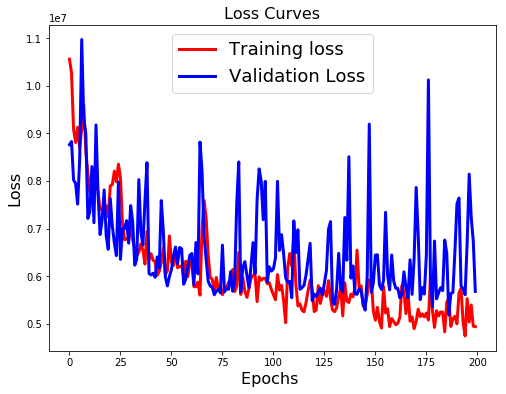

In [24]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

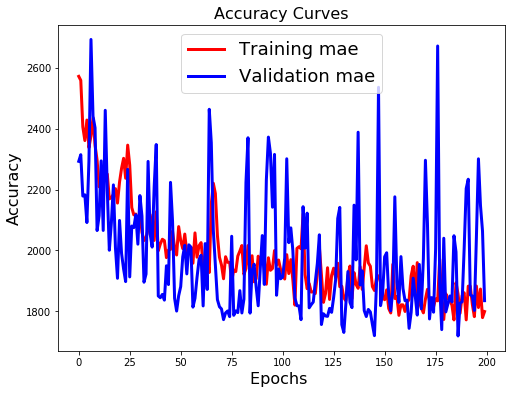

In [25]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [26]:
# Vorhersage generieren
predictions_46 = model.predict(Xtest_46)

predictions_train_46=model.predict(Xtrain_46)

In [27]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_46, predictions_46)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_46, predictions_train_46)
print('Train MSE: %.3f' % mse_train)

Test MSE: 5678601.849
Train MSE: 4565000.124


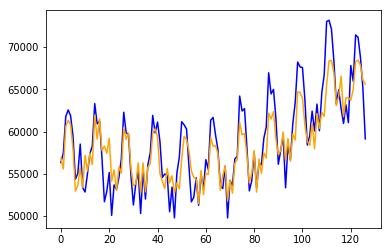

In [28]:
# Replizierbarkeit gewährleisten
np.random.seed(0)plt.plot(ytest_46, color='blue') 
plt.plot(predictions_46, color='orange')
plt.show()

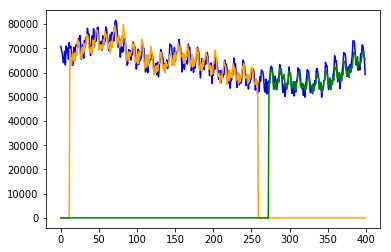

In [29]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_46)+(window_size+look_forward-1)] = predictions_train_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(predictions_train_46)+2*(window_size+look_forward):len(ZR)-1] = predictions_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [58]:
# Replizierbarkeit gewährleisten
np.random.seed(7)

In [59]:
# Modellanpassen: 12% 
history_reg=model.fit(Xtrain_12, ytrain_12, nb_epoch=25, batch_size=2, validation_data=(Xtest_12, ytest_12))

Train on 52 samples, validate on 22 samples
Epoch 1/25
52/52 [==============================] - 0s 3ms/step - loss: 540812.1864 - mean_absolute_error: 603.8182 - val_loss: 9111129.1477 - val_mean_absolute_error: 2569.2108
Epoch 2/25
 2/52 [>.............................] - ETA: 0s - loss: 97911.9844 - mean_absolute_error: 311.4473

C:\Anaconda\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


52/52 [==============================] - 0s 4ms/step - loss: 667612.1797 - mean_absolute_error: 665.3543 - val_loss: 6535513.4020 - val_mean_absolute_error: 2094.7326
Epoch 3/25
52/52 [==============================] - 0s 3ms/step - loss: 893223.4174 - mean_absolute_error: 762.1800 - val_loss: 7039639.4034 - val_mean_absolute_error: 2225.3967
Epoch 4/25
52/52 [==============================] - 0s 3ms/step - loss: 598034.9273 - mean_absolute_error: 630.2084 - val_loss: 8244989.2045 - val_mean_absolute_error: 2418.9228
Epoch 5/25
52/52 [==============================] - 0s 3ms/step - loss: 508566.1945 - mean_absolute_error: 579.9283 - val_loss: 9980856.5341 - val_mean_absolute_error: 2724.0238
Epoch 6/25
52/52 [==============================] - 0s 3ms/step - loss: 994778.8260 - mean_absolute_error: 846.0838 - val_loss: 6640941.3494 - val_mean_absolute_error: 2112.6898
Epoch 7/25
52/52 [==============================] - 0s 3ms/step - loss: 1220468.4790 - mean_absolute_error: 912.1704 - va

In [60]:
# Vorhersage generieren
predictions_12 = model.predict(Xtest_12)

predictions_train_12=model.predict(Xtrain_12)

In [61]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_12, predictions_12)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_12, predictions_train_12)
print('Train MSE: %.3f' % mse_train)

Test MSE: 7099655.941
Train MSE: 475648.832


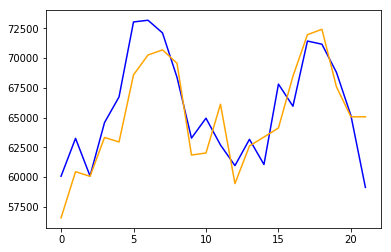

In [62]:
# Vorhersage und Testdaten abtragen
plt.plot(ytest_12, color='blue') 
plt.plot(predictions_12, color='orange') 
plt.show()

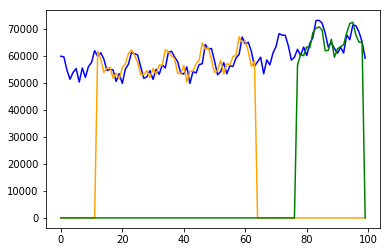

In [64]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_12)
trainPredictPlot[:]=[0]*len(ZR_12)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_12),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_12)+(window_size+look_forward-1)] = predictions_train_12

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_12)
testPredictPlot[:]=[0]*len(ZR_12)
testPredictPlot = testPredictPlot.reshape(len(ZR_12),1)
testPredictPlot[len(predictions_train_12)+2*(window_size+look_forward)-1:len(ZR_12)-1] = predictions_12
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_12, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()